In [1]:
from espei.datasets import load_datasets
from espei.error_functions.context import setup_context
from espei.error_functions.zpf_error import calculate_zpf_error
from pycalphad import Database
from glob import glob
import numpy as np

ds = load_datasets(glob('2020-05-28-Cr-Ni-ZPF/input-data/run/ZPF/*.json'))
#ds = load_datasets(['UQ/Cr-Ni-run/run/ZPF/CR-NI-ZPF-BCC_A2-FCC_A1-zhang2014impurity.json'])
dbf = Database('dft.tdb')
param_symbol_labels = {
'VV0000': 'L(A1;1)B',
'VV0001': 'L(A1;1)A',
'VV0002': 'L(A1;0)B',
'VV0003': 'L(A1;0)A',
'VV0004': 'L(A2;1)B',
'VV0005': 'L(A2;1)A',
'VV0006': 'L(A2;0)B',
'VV0007': 'L(A2;0)A',
'VV0008': 'L(LIQUID;1)B',
'VV0009': 'L(LIQUID;1)A',
'VV0010': 'L(LIQUID;0)B',
'VV0011': 'L(LIQUID;0)A'
}
dbf.elements = ['CR', 'NI', 'VA'] # workaround issue with callables of subsystem
ctx = setup_context(dbf, ds)
# weight from YAML file
ctx['zpf_kwargs']['data_weight'] = 20.0
max_phase_regions = max([len(data['phase_regions']) for data in ctx['zpf_kwargs']['zpf_data']])
print('max_phase_regions', max_phase_regions)
# shape: chain, sample, param_symbol
param_trace = np.load('2020-05-28-Cr-Ni-ZPF/trace-zpf.npy')
print('param_trace.shape', param_trace.shape)
#lnprob = np.load('UQ/Cr-Ni-run/2020-05-28-Cr-Ni-ZPF/lnprob.npy')
#lnprob_zpf = np.load('2020-05-28-Cr-Ni-ZPF/lnprob-zpf.npy')
#print('lnprob_zpf.shape', lnprob_zpf.shape)

max_phase_regions 49
param_trace.shape (24, 50, 12)


In [4]:
from tqdm.auto import tqdm
parameter_trials = []
# chain, sample, dataset, phase_region, [param_symbol]
calc_lnprob = np.zeros((param_trace.shape[0],param_trace.shape[1],len(ds), max_phase_regions))
calc_lnprobgrad = np.zeros((param_trace.shape[0],param_trace.shape[1],len(ds), max_phase_regions, param_trace.shape[2]))
calc_lnprob = np.load('2020-06-03-zpf-lnprob.npy')
calc_lnprobgrad = np.load('2020-06-03-zpf-lnprobgrad.npy')

#for chain_idx in tqdm(range(calc_lnprob.shape[0]), desc='Chains'):
#    for iter_idx in tqdm(range(50), desc=f'Chain {chain_idx}'):
#        zpf_prob_error, zpf_prob_error_gradient = calculate_zpf_error(parameters=param_trace[chain_idx, iter_idx, :],
#                                                                      **ctx.get('zpf_kwargs'))
#        calc_lnprob[chain_idx, iter_idx, :, :] = zpf_prob_error
#        calc_lnprobgrad[chain_idx, iter_idx, :, :, :] = np.array(zpf_prob_error_gradient)

Text(0, 0.5, 'lnprob')

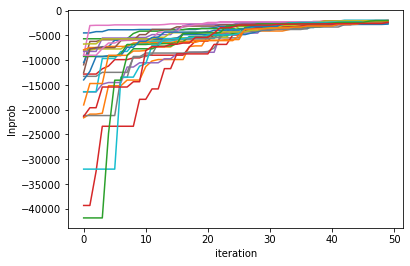

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
for chain_idx in range(calc_lnprob.shape[0]):
    plt.plot(np.arange(50), calc_lnprob[chain_idx, :, :].sum(axis=(-2, -1)))
plt.xlabel('iteration')
plt.ylabel('lnprob')

Text(0.5, 1.0, 'Cr-Ni Chain Avg Trial 0')

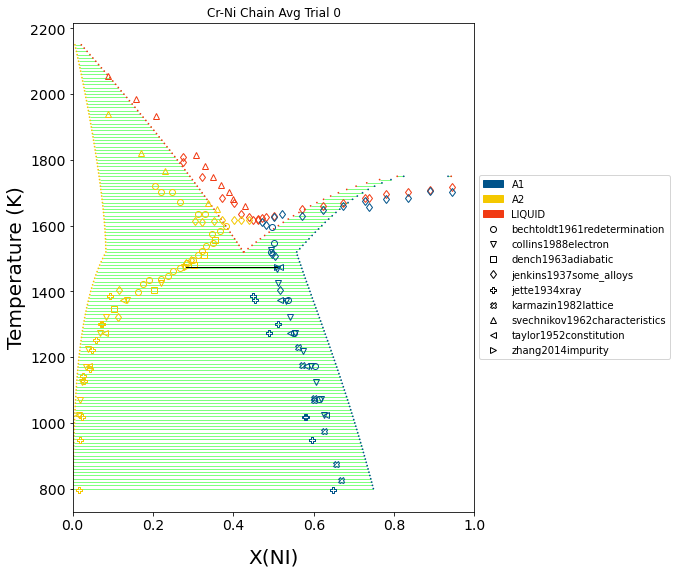

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from espei.plot import dataplot
from pycalphad import variables as v
from pycalphad import binplot
from pycalphad.core.solver import InteriorPointSolver, SundmanSolver

fig = plt.figure(figsize=(9,9))
ax = fig.gca()
trial = 0
chain = 'Avg'
binplot(dbf, ['CR', 'NI', 'VA'], ['A1','A2', 'LIQUID'], {v.P: 101325, v.T: (800, 2200, 10), v.X('NI'): (0,1,0.02), v.N:1},
        plot_kwargs={'ax': ax},
        eq_kwargs={'solver': SundmanSolver(),
                   'parameters': dict(zip(ctx['symbols_to_fit'], np.mean(param_trace[:, trial, :], axis=0)))})
dataplot(['CR', 'NI', 'VA'], ['A1', 'A2', 'LIQUID'], {v.P: 101325, v.T: (1,1,1), v.X('NI'): (1, 1, 1)}, ds, ax=ax)
ax.set_title(f'Cr-Ni Chain {chain} Trial {trial}')

Text(0.5, 1.0, 'Cr-Ni Chain Avg Trial 49')

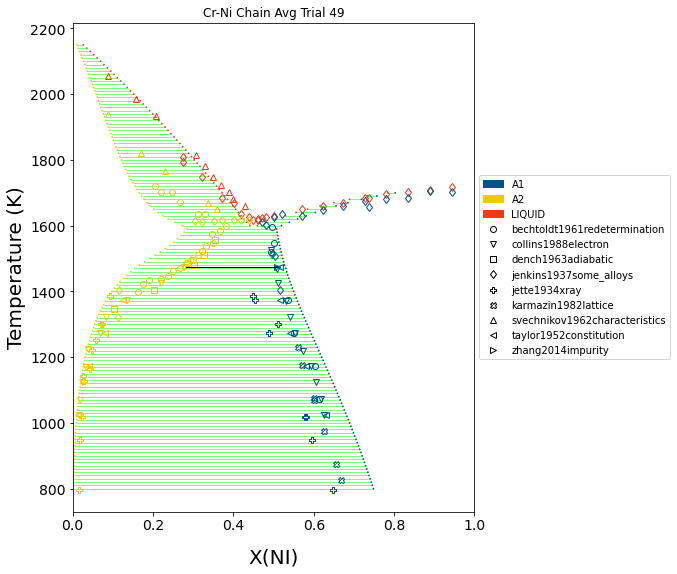

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from espei.plot import dataplot
from pycalphad import variables as v
from pycalphad import binplot
from pycalphad.core.solver import InteriorPointSolver, SundmanSolver

fig = plt.figure(figsize=(9,9))
ax = fig.gca()
trial = 49
chain = 'Avg'
binplot(dbf, ['CR', 'NI', 'VA'], ['A1','A2', 'LIQUID'], {v.P: 101325, v.T: (800, 2200, 10), v.X('NI'): (0,1,0.02), v.N:1},
        plot_kwargs={'ax': ax},
        eq_kwargs={'solver': SundmanSolver(),
                   'parameters': dict(zip(ctx['symbols_to_fit'], np.mean(param_trace[:, trial, :], axis=0)))})
dataplot(['CR', 'NI', 'VA'], ['A1', 'A2', 'LIQUID'], {v.P: 101325, v.T: (1,1,1), v.X('NI'): (1, 1, 1)}, ds, ax=ax)
ax.set_title(f'Cr-Ni Chain {chain} Trial {trial}')

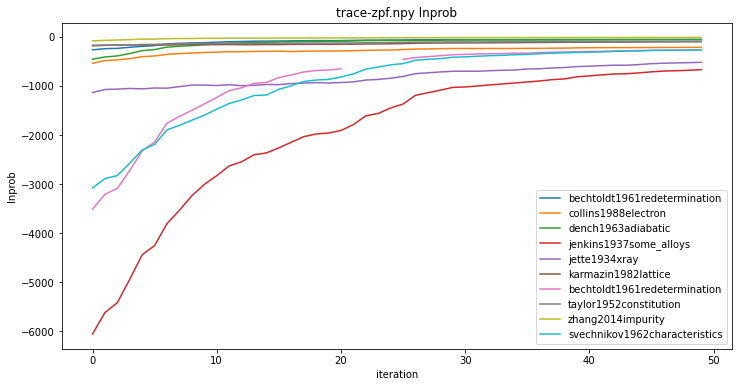

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    data_calc_lnprob = np.sum(calc_lnprob[:, :, data_idx, :], axis=-1)
    avg_calc_lnprob = np.mean(data_calc_lnprob, axis=0)
    std_calc_lnprob = np.std(data_calc_lnprob, axis=0)
    ax.plot(np.arange(50), avg_calc_lnprob, label=dataset['dataset_reference'])
    #ax.fill_between(np.arange(50), avg_calc_lnprob+std_calc_lnprob, avg_calc_lnprob-std_calc_lnprob, alpha=0.1)
ax.set_xlabel('iteration')
ax.set_ylabel('lnprob')
ax.set_title('trace-zpf.npy lnprob')
ax.legend()

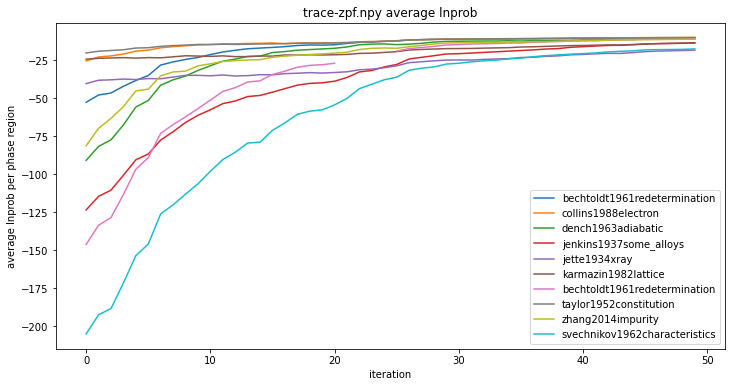

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    data_calc_lnprob = np.sum(calc_lnprob[:, :, data_idx, :], axis=-1)
    avg_calc_lnprob = np.mean(data_calc_lnprob, axis=0)
    std_calc_lnprob = np.std(data_calc_lnprob, axis=0)
    num_phase_regions = len(dataset['phase_regions'])
    ax.plot(np.arange(50), avg_calc_lnprob / num_phase_regions, label=dataset['dataset_reference'])
    #ax.fill_between(np.arange(50), (avg_calc_lnprob+std_calc_lnprob) / num_phase_regions,
    #                               (avg_calc_lnprob-std_calc_lnprob) / num_phase_regions, alpha=0.1)
ax.set_xlabel('iteration')
ax.set_ylabel('average lnprob per phase region')
ax.set_title('trace-zpf.npy average lnprob')
ax.legend()

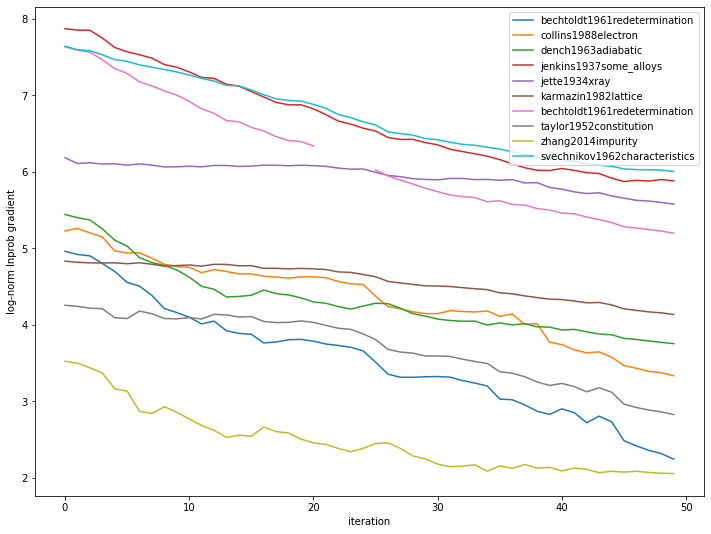

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,9))
ax = fig.gca()
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    data_calc_lnprobgrad = np.sum(calc_lnprobgrad[:, :, data_idx, :, :], axis=-2)
    mean_calc_lnprobgrad = np.mean(data_calc_lnprobgrad, axis=0)
    ax.plot(np.arange(50), np.log(np.linalg.norm(mean_calc_lnprobgrad, axis=-1)), label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('log-norm lnprob gradient')
ax.legend()

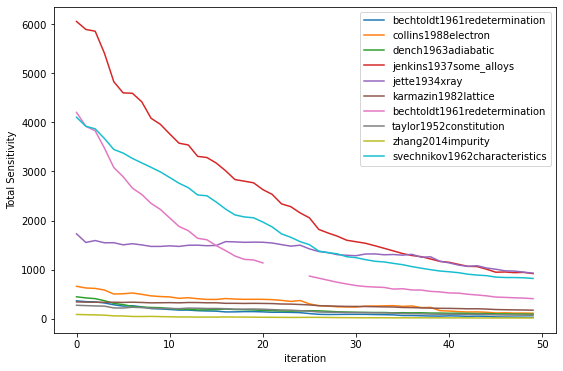

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
trace_param_std = np.std(param_trace[:, :, :], axis=(0, 1))
tdbdb_param_std = 0 # TODO
# Averaging Scheme No. 1 -- what other possibilities?
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    data_calc_lnprobgrad = np.sum(calc_lnprobgrad[:, :, data_idx, :, :], axis=-2)
    mean_calc_lnprobgrad = np.mean(data_calc_lnprobgrad, axis=0)
    ax.plot(np.arange(50), np.abs(mean_calc_lnprobgrad).dot(trace_param_std), label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('Total Sensitivity')
ax.legend()

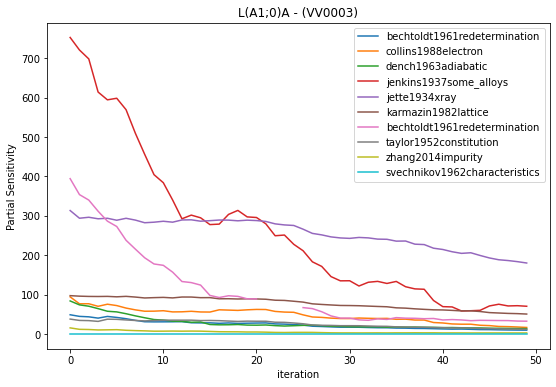

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
trace_param_std = np.std(param_trace[:, :, :], axis=(0, 1))
tdbdb_param_std = 0 # TODO
param_idx = 3
# Averaging Scheme No. 1 -- what other possibilities?
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    data_calc_lnprobgrad = np.sum(calc_lnprobgrad[:, :, data_idx, :, :], axis=-2)
    mean_calc_lnprobgrad = np.mean(np.abs(data_calc_lnprobgrad[:, :, param_idx]), axis=0)
    ax.plot(np.arange(50), np.abs(mean_calc_lnprobgrad).dot(trace_param_std[param_idx]), label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('Partial Sensitivity')
ax.set_title('{0} - ({1})'.format(param_symbol_labels['VV0003'], 'VV0003'))
ax.legend()

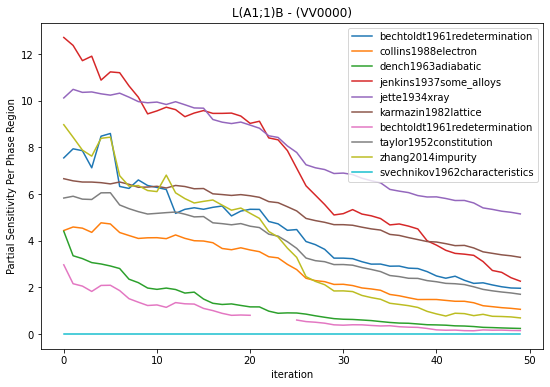

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
trace_param_std = np.std(param_trace[:, :, :], axis=(0, 1))
tdbdb_param_std = 0 # TODO
param_idx = 0
# Averaging Scheme No. 1 -- what other possibilities?
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    num_phase_regions = len(dataset['phase_regions'])
    data_calc_lnprobgrad = np.sum(calc_lnprobgrad[:, :, data_idx, :, :], axis=-2)
    mean_calc_lnprobgrad = np.mean(np.abs(data_calc_lnprobgrad[:, :, param_idx]), axis=0)
    ax.plot(np.arange(50), np.abs(mean_calc_lnprobgrad).dot(trace_param_std[param_idx]) / num_phase_regions, label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('Partial Sensitivity Per Phase Region')
ax.set_title('{0} - ({1})'.format(param_symbol_labels['VV0000'], 'VV0000'))
ax.legend()

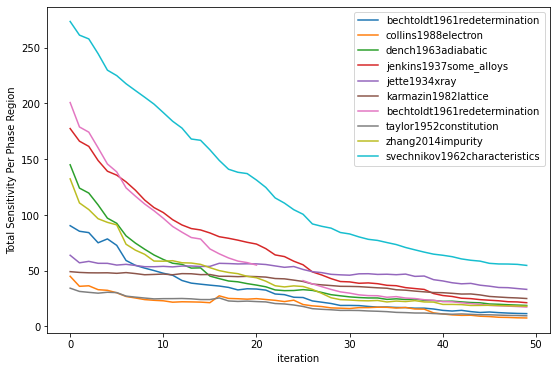

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
trace_param_std = np.std(param_trace[:, :, :], axis=(0, 1))
tdbdb_param_std = 0 # TODO
# Averaging Scheme No. 1 -- what other possibilities?
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    num_phase_regions = len(dataset['phase_regions'])
    data_calc_lnprobgrad = np.sum(calc_lnprobgrad[:, :, data_idx, :, :], axis=-2)
    mean_calc_lnprobgrad = np.mean(np.abs(data_calc_lnprobgrad[:, :, :]), axis=0)
    ax.plot(np.arange(50), np.abs(mean_calc_lnprobgrad).dot(trace_param_std) / num_phase_regions, label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('Total Sensitivity Per Phase Region')
ax.legend()

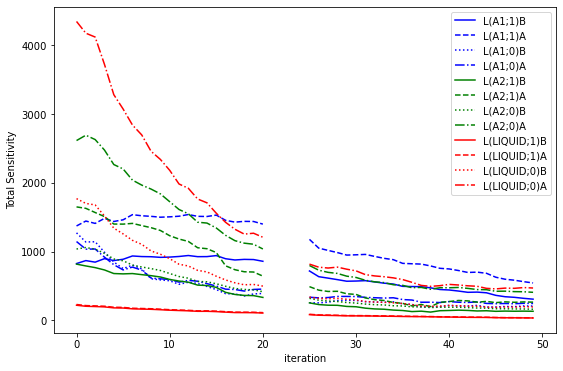

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from cycler import cycler

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
custom_cycler = (cycler(color='bgrcmyk') *
                 cycler(linestyle=['-', '--', ':', '-.']))
ax.set_prop_cycle(custom_cycler)
trace_param_std = np.std(param_trace[:, :, :], axis=(0,1))
tdbdb_param_std = 0 # TODO
total_calc_lnprobgrad = np.sum(np.mean(calc_lnprobgrad[:, :, :, :, :], axis=0), axis=(1, 2))
total_calc_sensitivity = total_calc_lnprobgrad * trace_param_std
for param_idx, param_symbol in enumerate(ctx['symbols_to_fit']):
    ax.plot(np.arange(50), np.abs(total_calc_sensitivity[:, param_idx]), label=param_symbol_labels[param_symbol])

ax.set_xlabel('iteration')
ax.set_ylabel('Total Sensitivity')
ax.legend()

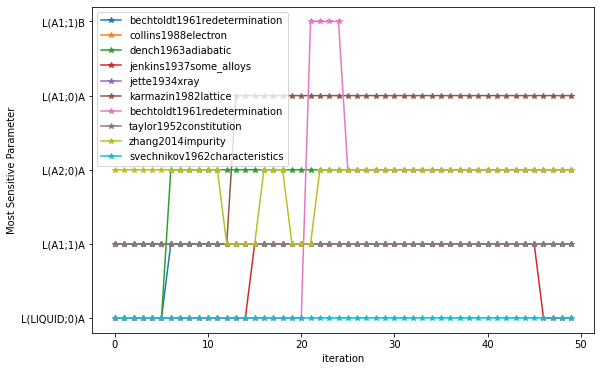

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
trace_param_std = np.std(param_trace[:, :, :], axis=(0,1))
tdbdb_param_std = 0 # TODO
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    data_calc_lnprobgrad = np.sum(calc_lnprobgrad[:, :, data_idx, :, :], axis=-2)
    sensitivities = np.abs(np.mean(data_calc_lnprobgrad, axis=0)) * trace_param_std[np.newaxis, :]
    arg_sensitivities = np.argmax(sensitivities, axis=1)
    param_sensitivities = [param_symbol_labels[ctx['symbols_to_fit'][i]] for i in arg_sensitivities]
    ax.plot(np.arange(50), param_sensitivities, label=dataset['dataset_reference'], marker='*')
ax.set_xlabel('iteration')
ax.set_ylabel('Most Sensitive Parameter')
ax.legend(loc='upper left')

In [69]:
compositions = []
temperatures = []
sensitivities = []
trace_param_std = np.std(param_trace[:, :, :], axis=(0,1))
tdbdb_param_std = 0 # TODO
iteration_idx = 49
averaged_calc_lnprobgrad = np.mean(np.abs(calc_lnprobgrad), axis=0)
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    for phase_region_idx, phase_region in enumerate(dataset['phase_regions']):
        temperature = phase_region.potential_conds[v.T]
        if phase_region.comp_conds[0].get(v.X('CR'), None) is not None:
            composition = 1 - list(phase_region.comp_conds[0].values())[0]
        else:
            composition = list(phase_region.comp_conds[0].values())[0]
        point_sens = np.multiply(averaged_calc_lnprobgrad[iteration_idx, data_idx, phase_region_idx, :], trace_param_std)
        compositions.append(composition)
        temperatures.append(temperature)
        sensitivities.append(point_sens)
        #print(temperature, composition, point_sens)
        #print(data_idx, phase_region_idx, point_sens)

Text(0.5, 0.98, 'Partial Sensitivities - Chain Avg of Iteration 49')

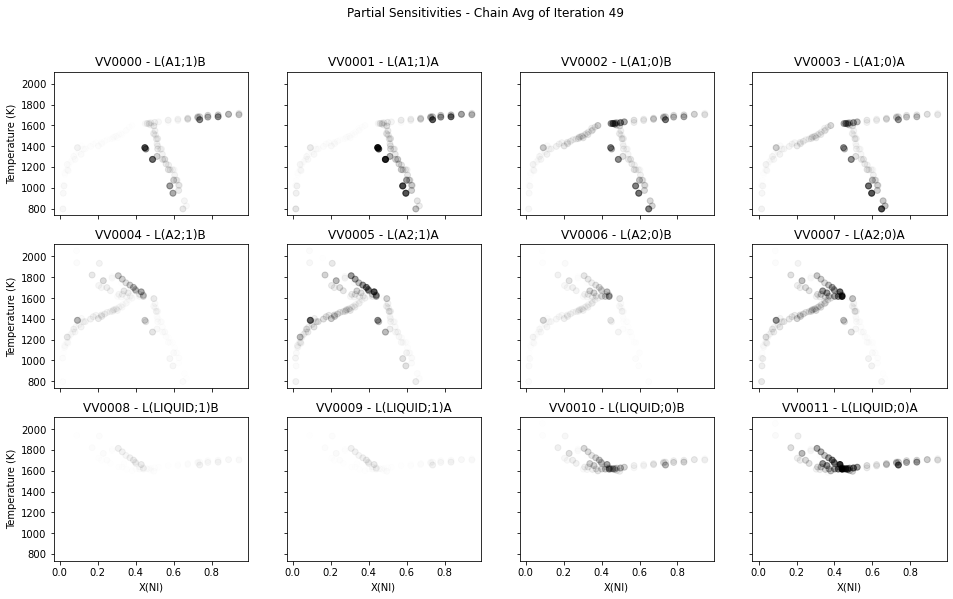

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(16,9))
sensitivities = np.array(sensitivities)

sorted_param_labels = sorted(param_symbol_labels.items())

largest_sensitivity = np.max(sensitivities)

for param_idx, param_item in enumerate(sorted_param_labels):
    param_symbol, param_label = param_item
    colors = [(0, 0, 0, a/largest_sensitivity) for a in sensitivities[:, param_idx]]
    axs.flat[param_idx].scatter(compositions, temperatures, c=colors)
    axs.flat[param_idx].set_title(f'{param_symbol} - {param_label}')

for ax in axs.flat:
    ax.set(xlabel='X(NI)', ylabel='Temperature (K)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.suptitle(f'Partial Sensitivities - Chain Avg of Iteration {iteration_idx}')

Text(0.5, 0.98, 'Parameter Plots')

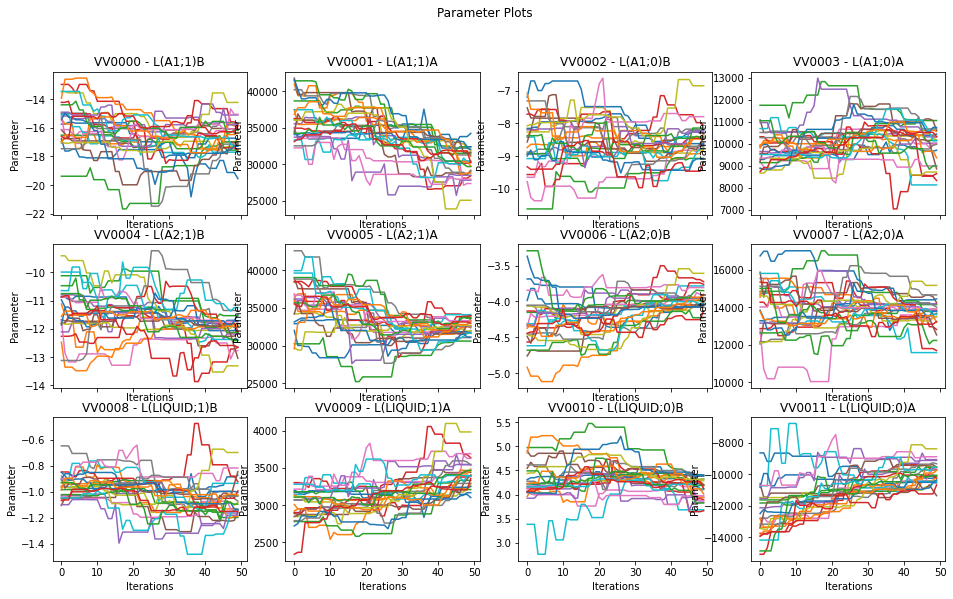

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, sharex=True, figsize=(16,9))

sorted_param_labels = sorted(param_symbol_labels.items())

largest_sensitivity = np.max(sensitivities)

for param_idx, param_item in enumerate(sorted_param_labels):
    param_symbol, param_label = param_item
    for chain_idx in range(param_trace.shape[0]):
        axs.flat[param_idx].plot(np.arange(param_trace.shape[1]), param_trace[chain_idx, :, param_idx])
    axs.flat[param_idx].set_title(f'{param_symbol} - {param_label}')

for ax in axs.flat:
    ax.set(xlabel='Iterations', ylabel='Parameter')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
fig.suptitle('Parameter Plots')